# Intro to Digital Audio

To be able to work with audio signals in a computer, we need to create a series of discrete values from a continuous sound wave.

This notebook will walk you through the fundamentals of how audio is represented in Python, how to create a custom dataset of music using yt-dlp/musicdl, and how to visualize the waveform of an audio file.

<a href="https://colab.research.google.com/github/MichiganDataScienceTeam/F25-Shazam/blob/main/notebooks/week1_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pandas numpy matplotlib librosa scipy yt-dlp pyaudio


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import scipy


# 1/3: Some Terminology

TODO: convert to paragraph form 

Explain Frequency, discretization of audio:

1 Hertz = 1 vibration / second 

vibration of air particles

Amplitude: decibels

![metadata](./asset/sample_metadata.png)

Let's break down some common aspects of an audio file:

- **sample rate** - number of samples per second (Hz). The sampling rate determines the time resolution of our representation.
- **bit depth** - The number of bits used to store each sample. The larger the bit depth, the more precision we have to store amplitude information (amplitude resolution).


time is digitized using the sample rate, amplitude is digitized using bit depth

$\mathrm{bit rate} = \mathrm{sr}\times\mathrm{bit depth}\times\textrm{number of channels}$

mp3 files are measured in bit rate since they do not store the associated bit depths

The sampling interval is defined as the reciprocal of the sampling rate, and it represents the time duration between two consecutive samples in a discrete time signal. If the sampling rate is 44100 times per second, then the sampling interval is 1/44100.


try different values of `sample_rate` and `freq_Hz`

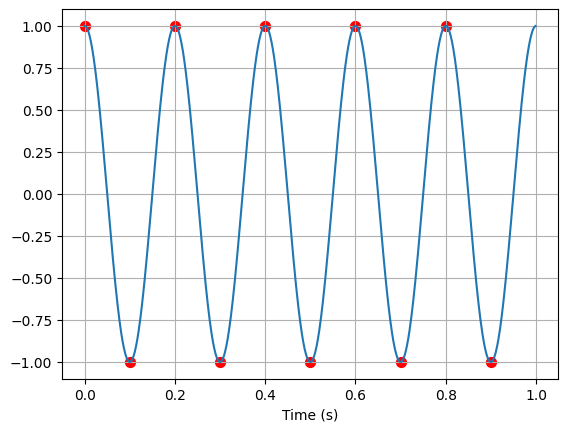

In [3]:
# frequency of the audio signal
freq_Hz = 5

# rate at which audio is being sampled
sample_rate_Hz = 10

x_continuous = np.linspace(0, 1, 1000, endpoint=False)
y_continuous = np.cos(freq_Hz * 2*np.pi*x_continuous)

x_discrete = np.linspace(0, 1, sample_rate_Hz, endpoint=False)
y_discrete = np.cos(freq_Hz * 2*np.pi*x_discrete)

plt.plot(x_continuous, y_continuous)
plt.scatter(x_discrete, y_discrete, color="red", s=50)
plt.xlabel("Time (s)")
plt.grid()


## Good to Know Sampling Theorem:

If a signal contains no frequencies higher than $f_\mathrm{max}$, then the signal can be perfectly reconstructed when sampled at a rate $sr > 2f_\mathrm{max}$. In other words, the maximum reconstructable frequency is strictly less than $sr/2$. This is called the Nyquist-Shannon sampling theorem.

Explain aliasing briefly

Question: In order to cover the human hearing range of 20 Hz to 20 kHz, what is the minimum sampling rate required?

In [4]:
# sampling_rate_required = ???

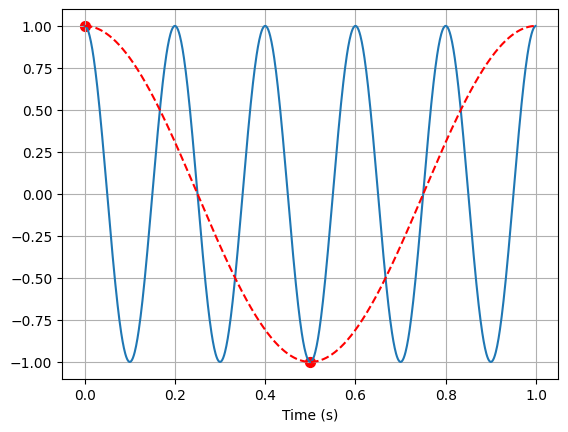

In [5]:
sample_rate_Hz = 2

freq_Hz = 5

freq_reconstructable_up_to = sample_rate_Hz / 2

x_continuous = np.linspace(0, 1, 1000, endpoint=False)
y_continuous = np.cos(freq_Hz * 2*np.pi*x_continuous)

x_undersampled = np.linspace(0, 1, 1000, endpoint=False)
y_undersampled = np.cos(freq_reconstructable_up_to * 2*np.pi*x_undersampled)

x_discrete = np.linspace(0, 1, sample_rate_Hz, endpoint=False)
y_discrete = np.cos(freq_Hz * 2*np.pi*x_discrete)

plt.plot(x_continuous, y_continuous)
plt.plot(x_undersampled, y_undersampled, color="red", linestyle="--")
plt.scatter(x_discrete, y_discrete, color="red", s=50)
plt.xlabel("Time (s)")
plt.grid()

# 2/3: Obtaining audio files

To create a database of songs that our Shazam clone will be able to recognize, we can use the [yt-dlp](https://github.com/yt-dlp/yt-dlp) Python package to download audio files directly from YouTube

In [6]:
import yt_dlp
import os

# add any youtube video url here, 
# copied from browser address bar
youtube_url = ""

yt_audio_path = "yt_sample.wav"

ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': "yt_sample.%(ext)s",  # output file
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',     # save as wav file
        }],
        #'cookiefile': 'cookies.txt',
    }
if youtube_url != "":
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])



## musicdl: helper script for downloading audio

For convienience, we've created a yt-dlp wrapper program that accepts urls from either YouTube or Spotify, and downloads the respective audio files to a specified folder.

In [7]:
!git clone --depth 1 https://github.com/dennisfarmer/musicdl.git
%pip install -e ./musicdl
from musicdl.yt import YoutubeDownloader

fatal: destination path 'musicdl' already exists and is not an empty directory.
Obtaining file:///Users/dennisfj/Michigan/F25-Shazam-Clone/notebooks/musicdl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for musicdl (pyproject.toml) ... done
  Created wheel for musicdl: filename=musicdl-2025.7-0.editable-py3-none-any.whl size=5829 sha256=d0283add4842bc1b4dda04e0fb0d150fb86c174ac685495fc975bfd09216aa0c
  Stored in directory: /private/var/folders/9f/sb0fz4m93959ldp0sm0y2nz00000gn/T/pip-ephem-wheel-cache-a2xmzik_/wheels/92/c2/00/cd369a51c038dbc57ea2ce489e3dca1120c66d6476e76bfc59
Successfully built musicdl
  Attempting uninstall: musicdl
    Found existing installation: musicdl 2025.7
    Uninstalling musicdl-2025.7:
      Successfully uninstalled musicdl-2025.7

[notice] A new release of pip is available: 25.0 

In [8]:
help(YoutubeDownloader.download)

Help on function download in module musicdl.yt:

download(self, url_list: list[str], filename_list: list[str] | None = None)
    url_list is a list of youtube urls, and optionally filename_list
    is a list of the same length specifying the respecive filenames with
    their extension. Default behavior is to use the video title and uploader
    as the filename.
    ```
    ydl = YoutubeDownloader()
    tracks_info = ydl.download([
            "https://www.youtube.com/watch?v=TqxfdNm4gZQ",
            "https://www.youtube.com/watch?v=WhXgpkQ8E-Q"
            ])
    print(tracks_info[0])
    # {
    #   'youtube_url': 'https://www.youtube.com/watch?v=TqxfdNm4gZQ'
    #   'title': 'Brad Mehldau - The Garden'
    #   'artist': 'Nonesuch Records'
    #   'artwork_url': 'https://i.ytimg.com/vi/TqxfdNm4gZQ/hqdefault.jpg'
    #   'audio_path': './tracks/BradMehldauTheGarden_NonsuchRecords.wav'
    # }
    ```



In [9]:
from pprint import pprint

ydl = YoutubeDownloader(
    audio_directory="./tracks", 
    audio_format="wav"
)

youtube_urls = [
    "https://www.youtube.com/watch?v=TqxfdNm4gZQ"
]

tracks_info = ydl.download(youtube_urls)
pprint(tracks_info)

# write to csv
tracks_csv = "./tracks/tracks_info.csv"
tracks_df = pd.DataFrame(tracks_info)
tracks_df.to_csv(tracks_csv, index=False)

# read from csv
#with open(tracks_csv, "r") as f:
    #tracks_df = pd.read_csv(f)
    #tracks_list = list(tracks_df.to_dict(orient="records"))


[youtube] Extracting URL: https://www.youtube.com/watch?v=TqxfdNm4gZQ
[youtube] TqxfdNm4gZQ: Downloading webpage
[youtube] TqxfdNm4gZQ: Downloading tv simply player API JSON
[youtube] TqxfdNm4gZQ: Downloading tv client config
[youtube] TqxfdNm4gZQ: Downloading tv player API JSON
[info] TqxfdNm4gZQ: Downloading 1 format(s): 251
[download] Sleeping 4.00 seconds as required by the site...
[download] Destination: ./tracks/BradMehldauTheGarden_NonesuchRecords
[download] 100% of    7.25MiB in 00:00:02 at 3.04MiB/s   
[ExtractAudio] Destination: ./tracks/BradMehldauTheGarden_NonesuchRecords.wav
Deleting original file ./tracks/BradMehldauTheGarden_NonesuchRecords (pass -k to keep)
[{'artist': 'Nonesuch Records',
  'artwork_url': 'https://i.ytimg.com/vi/TqxfdNm4gZQ/hqdefault.jpg',
  'audio_path': './tracks/BradMehldauTheGarden_NonesuchRecords.wav',
  'title': 'Brad Mehldau - The Garden',
  'youtube_url': 'https://www.youtube.com/watch?v=TqxfdNm4gZQ'}]


# 3/3: Working with audio data in Python:

## Visualizing the amplitude and sample rate of an audio file

sample rate = 48000 Hz


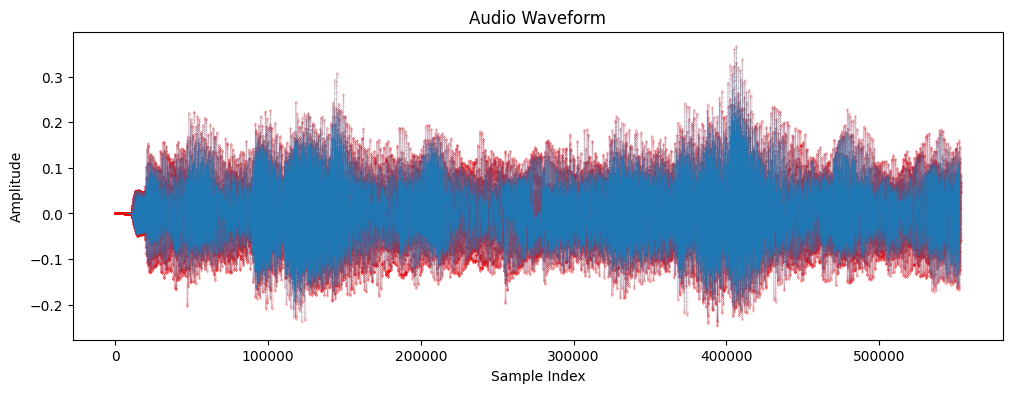

audio is digitally represented as a numpy.ndarray:


array([ 0.        ,  0.        ,  0.        , ..., -0.02311707,
       -0.01620483, -0.00933838], shape=(553231,), dtype=float32)

In [10]:
#audio_path = yt_audio_path
audio_path = "sample.wav"

# default is to convert to mono (1 channel)
audio, sr = librosa.load(audio_path, sr=None)  # sr=None uses the file's sampling rate
print(f"sample rate = {sr} Hz")

plt.figure(figsize=(12, 4))
plt.plot(audio, lw=0.1)  # interpolated waveform
plt.scatter(np.arange(len(audio)), audio, s=0.005, color="red")  # individual samples
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

print("audio is digitally represented as a numpy.ndarray:")
audio

## Downsampling

https://en.wikipedia.org/wiki/Downsampling_(signal_processing)

internally, downsampling (reducing the sample rate) performs the following process:
1. uses a low pass filter to remove higher frequency components to avoid aliasing (Sampling Theorem)
    - low pass: keep signals with frequency lower than a specified cutoff frequency
    - question: what would the cutoff frequency be if we resampled to 11,025 Hz?
2. keeps every nth sample using a sample step size ("decimation factor") of $(\mathrm{sr_{old}}/\mathrm{sr_{new}})$, 
    - the details of this process are not super important to know
    - if $(\mathrm{sr_{old}}/\mathrm{sr_{new}})$ is not an integer, first upsamples via interpolation, then downsamples with step size $\mathrm{sr_{old}}$.
    - upsampling: each original sample is separated by inserting $(\mathrm{sr_{new}}-1)$ zeros, then signal is interpolated with filter to smooth out discontinuities (replacing zeros)

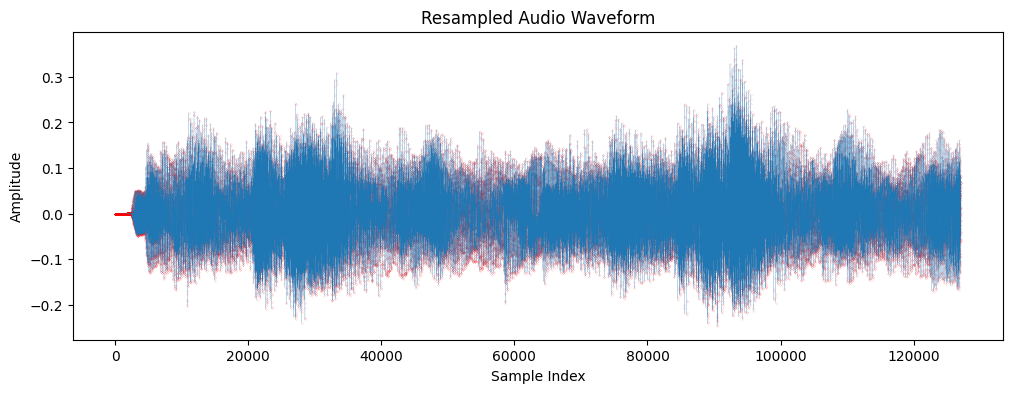

array([ 0.        ,  0.        ,  0.        , ..., -0.0577956 ,
       -0.03924554,  0.        ], shape=(127071,), dtype=float32)

In [11]:
# Resample from 48,000 Hz to 11,025 Hz
sr = 11_025
audio, sr = librosa.load(audio_path, sr=sr)

# cutoff_frequency = ???

# Question: how would you plot just the first 10 seconds of an audio file?
#            Modify the existing code to do this
# Hint: use sample rate

plt.figure(figsize=(12, 4))
plt.plot(audio, lw=0.1)  # interpolated waveform
plt.scatter(np.arange(len(audio)), audio, s=0.005, color="red")  # individual samples
plt.title("Resampled Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()
audio

# Task for today:

1) download the audio from any youtube video as a .wav file
2) downsample the file to 44.1 kHz
3) crop the audio to the first 10 seconds
4) visualize the waveform

In [12]:
# YOUR CODE HERE

---
# Next week: visualizing frequency using a spectrogram

In [13]:
import IPython.display as ipd
audio_path = "log_scale_perception.wav"
ipd.Audio(audio_path)

## Method 1: Librosa

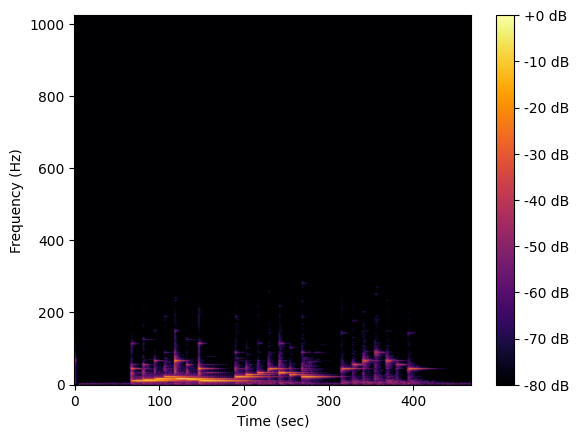

In [14]:
audio, sr = librosa.load(audio_path, sr=None) 

# parameters of the short-time Fourier transform:
# (algorithm that creates the spectrogram)
win_length = 2**11  # number of samples in each window
n_fft = win_length
hop_length = win_length // 4
window = scipy.signal.get_window("triang", Nx=win_length)

S = librosa.stft(audio, 
                       n_fft=n_fft, hop_length=hop_length, 
                       win_length=win_length, window=window)
S_magnitude = np.abs(S)  # |a+bi| = sqrt(a^2 + b^2)
S_db = librosa.amplitude_to_db(S_magnitude, ref=np.max)

im = plt.imshow(S_db, cmap="inferno", aspect="auto", origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Method 2: Scipy (what we'll use)

freq vector shape: (1025,)
time vector shape: (469,)
stft matrix shape: (1025, 469)


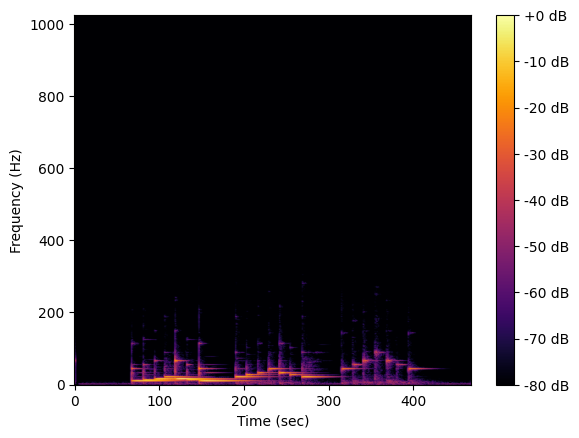

In [15]:
audio, sr = librosa.load(audio_path, sr=None) 

# parameters of the short-time Fourier transform:
# (algorithm that creates the spectrogram)
nperseg = win_length = 2**11  # number of samples in each window
nfft = n_fft = win_length
hop_length = win_length // 4
window = scipy.signal.get_window("triang", Nx=win_length)

# scipy.signal.stft also uses the sample rate to output 
# frequency (in Hz) and time (in seconds) vectors,
# corresponding to the rows and columns of the stft matrix 
# in "s_scipy"
fs=sr 
noverlap = nperseg - hop_length

freq_scipy, time_scipy, s_scipy = scipy.signal.stft(
    audio, 
    fs=fs, window="hann", nfft=nfft, 
    nperseg=nperseg, noverlap=noverlap
)

print(f"freq vector shape: {freq_scipy.shape}")
print(f"time vector shape: {time_scipy.shape}")
print(f"stft matrix shape: {s_scipy.shape}")

s_scipy_db = librosa.amplitude_to_db(np.abs(s_scipy), ref=np.max)

im = plt.imshow(s_scipy_db, cmap="inferno", aspect="auto", origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Recording from Microphone

In [16]:
import scipy.io.wavfile
import numpy as np
import pyaudio

def record_audio(n_seconds: int = 5) -> str:
    """
    records audio using computer microphone
    """
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 48000


    input("Press Enter to begin recording 🎤")
    print("🎤 Listening for music", end="\r")

    outfile = "microphone_sample.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    frames = []
    for _ in range(0, int(RATE / CHUNK * n_seconds)):
        data = stream.read(CHUNK)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    p.terminate()


    audio_np = np.frombuffer(b''.join(frames), dtype=np.int16)
    scipy.io.wavfile.write(outfile, RATE, audio_np)
    print(f"✅ Recording saved to {outfile}", end="\n")

    return outfile

#audio_path = record_audio()

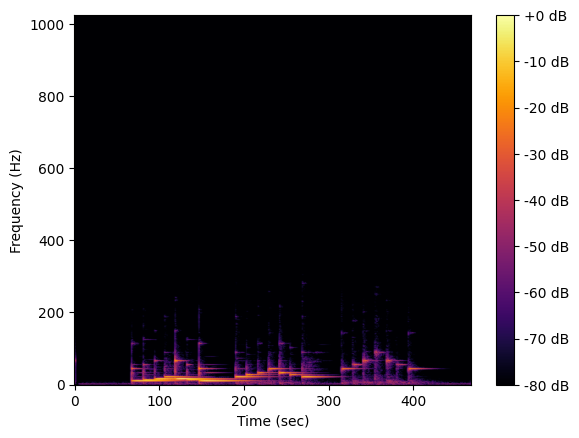

In [17]:
#audio_path = "microphone_sample.wav"

audio, sr = librosa.load(audio_path, sr=None) 
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
im = plt.imshow(S_db, cmap="inferno", aspect="auto", origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()